In [28]:
import pandas as pd
import datetime as dt
import numpy as np
import os

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [29]:
# Read data
data = pd.read_csv('../data/model_features.csv')
# data = pd.read_csv('../data/transformed_data_men_21_to_24.csv')
# data.drop('Unnamed: 0',axis=1,inplace=True)
data.columns = [col.replace('%','_perc') for col in data.columns]
data.columns = [col.replace('3','three_') for col in data.columns]
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,sos,srs,fg,fga,fg_perc,three_p,three_pa,three_p_perc,ft,fta,ft_perc,orb,drb,trb,ast,stl,blk,pf,tov,tov_perc,poss,ast_per_poss,ast_per_fg,tov_per_poss,ast_to_tov,poss_per_game,game_win_rate,gpt_sent_score_avg,de_opp,oe_opp,te_opp,pace_opp,physicality_score_opp,sos_opp,srs_opp,fg_opp,fga_opp,fg_perc_opp,three_p_opp,three_pa_opp,three_p_perc_opp,ft_opp,fta_opp,ft_perc_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,pf_opp,tov_opp,tov_perc_opp,poss_opp,ast_per_poss_opp,ast_per_fg_opp,tov_per_poss_opp,ast_to_tov_opp,poss_per_game_opp,game_win_rate_opp,gpt_sent_score_avg_opp,conf_rank,conf_rank_opp,luck,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,three_mean_plus_minus,three_mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,-6.37,6.27,27.103448,60.413793,0.449,7.62069,22.172414,0.344,13.896552,20.482759,0.678,11.344828,24.758621,36.103448,17.689655,9.724138,2.965517,19.103448,13.586207,16.2,39.074138,0.45272,0.652672,0.347703,1.30203,1.347384,0.827586,48.666667,98.254994,103.126160,1.049577,67.0,8.390000,0.30,1.65,24.800000,56.640000,0.438,8.040000,23.000000,0.350,11.800000,16.920000,0.697,10.120000,25.760000,35.880000,11.800000,7.360000,2.52,17.240000,13.560000,17.3,36.277000,0.325275,0.475806,0.373791,0.870206,1.451080,0.520000,73.333333,15.0,15.0,0.666667,0.000000,0.0,NaN,0.0,NaN,14.333333,-3.333333,0,0,NaN
1,1,0,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,-6.37,6.27,27.103448,60.413793,0.449,7.62069,22.172414,0.344,13.896552,20.482759,0.678,11.344828,24.758621,36.103448,17.689655,9.724138,2.965517,19.103448,13.586207,16.2,39.074138,0.45272,0.652672,0.347703,1.30203,1.347384,0.827586,48.666667,100.518548,106.741125,1.061905,69.0,9.027778,-8.22,-6.66,27.148148,59.888889,0.453,7.185185,21.222222,0.339,12.851852,17.111111,0.751,12.629630,21.851852,34.481481,13.222222,6.777778,2.00,17.481481,14.703704,17.8,37.350000,0.354009,0.487040,0.393673,0.899244,1.383333,0.518519,63.000000,15.0,22.0,0.666667,0.571429,0.0,NaN,0.0,NaN,14.333333,-0.333333,1,2,NaN
2,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,-6.37,6.27,27.103448,60.413793,0.449,7.62069,22.172414,0.344,13.896552,20.482759,0.678,11.344828,24.758621,36.103448,17.689655,9.724138,2.965517,19.103448,13.586207,16.2,39.074138,0.45272,0.652672,0.347703,1.30203,1.347384,0.827586,48.666667,108.277778,93.500000,0.863520,72.0,7.550000,-2.09,-12.73,25.000000,59.760000,0.418,5.320000,15.880000,0.335,12.000000,17.440000,0.688,8.480000,25.640000,34.120000,9.440000,5.640000,3.00,18.840000,13.080000,16.1,37.884000,0.249182,0.377600,0.345264,0.721713,1.515360,0.200000,59.333333,15.0,12.0,0.666667,0.444444,0.0,NaN,0.0,0.000000,14.333333,-5.666667,2,1,NaN
3,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,-6.37,6.27,27.103448,60.413793,0.449,7.62069,22.172414,0.344,13.896552,20.482759,0.678,11.344828,24.758621,36.103448,17.689655,9.724138,2.965517,19.103448,13.586207,16.2,39.074138,0.45272,0.652672,0.347703,1.30203,1.347384,0.827586,48.666667,90.289855,106.304348,1.177368,69.0,8.287500,-3.02,-7.28,26.500000,56.450000,0.469,5.500000,14.550000,0.378,14.850000,20.600000,0.721,8.500000,23.450000,31.950000,14.700000,10.450000,2.65,19.550000,11.550000,14.8,39.335000,0.373713,0.554717,0.293632,1.272727,1.966750,0.500000,68.666667,15.0,15.0,0.666667,0.000000,0.0,NaN,0.0,NaN,14.333333,-10.333333,3,0,0.5
4,0,1,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,-6.37,6.27,27.103448,60.413793,0.449,7.62069,22.172414,0.344,13.896552,20.482759,0.678,11.344828,24.758621,36.103448,17.689655,9.724138,2.965517,19.103448,13.586207,16.2,39.074138,0.45272,0.652672,0.347703,1.30203,1.347384,0.827586,48.666667,93.532338,107.309606,1.147300,67.0,8.353448,7.28,16.59,25.310345,57.655172,0.439,6.379310,18.034483,0.354,15.517241,21.862069,0.710,11.482759,23.482759,34.965517,13.000000,7.137931,4.00,17.310345,10.793103,13.7,35.005172,0.371374

In [30]:
# Check for duplicates
num_duplicates = data.loc[data.duplicated()].shape[0]
print(f'{num_duplicates} duplicates')
if num_duplicates > 0:
#     print(data.loc[data.duplicated()].head())
    data = data.drop_duplicates()
    print('duplicates removed')

0 duplicates


## Create helper functions

In [31]:
def get_odds_ratios(model, save_name=None):
    # Build a dataframe with odds ratios and their confidence intervals.
    if type(model) in [type(LogisticRegression()), type(XGBClassifier())]:
#         params = np.concatenate((model.intercept_, model.coef_[0]),axis=0)
        params = pd.Series(model.coef_[0],index=model.feature_names_in_)
    else:
        params = model.params
    odds_ratios = pd.DataFrame(
        {
            "OR": params
#             "Lower CI": model.conf_int()[0],
#             "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the odds ratios
#     or_string = 
    print('\nOdds Ratios:')
    print(odds_ratios.sort_values('OR',ascending=False))
    odds_ratios.sort_values('OR',ascending=False).to_csv(f'../eda/{save_name}_odds_ratios.csv')
    
    # Print prediction table
    if type(model) not in [type(LogisticRegression()), type(XGBClassifier())]:
        print('\nPrediction table:')
        print(model.pred_table())
    if save_name is not None:
        np.savetxt(f'../eda/{save_name}_prediction_table.out',model.pred_table(),
                   header=f'{save_name} prediction table')
    
    return None

In [32]:
def get_confusion_matrix(model, validation, response_var):
    y_pred = model.predict(validation)
    prediction = list(map(round, y_pred))

    # Create a sklearn confusion matrix
    cm = confusion_matrix(validation[response_var], prediction)
    print ("\nConfusion Matrix : \n", cm)

    # We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
    print('\nTest accuracy = ', accuracy_score(validation[response_var], prediction))
    
    # Print classfication report
    print('\nClassification Report: \n' , classification_report(validation[response_var],prediction))
    
    return None

## 1 - Statsmodels Logistic Regression - fillna

         Current function value: 0.451882
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Accuracy: 0.7844129554655871
F1-Score: 0.787
ROC/AUC Score for Logistic Regression:  0.784368123199482


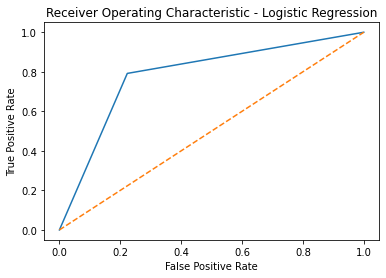

In [34]:
resp_var = data.columns[0]
pred_vars = data.columns[1:].tolist()

train, test = train_test_split(data.fillna(0),test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
get_odds_ratios(log_reg)


Odds Ratios:
                         OR
matchup_win_rate   8.639409
luck               2.413231
game_win_rate      1.587318
fan_favorite       1.568422
upset_rate         1.247696
...                     ...
poss_per_game      0.849206
upset_rate_opp     0.825374
game_win_rate_opp  0.628960
fan_favorite_opp   0.624202
luck_opp           0.425216

[84 rows x 1 columns]

Prediction table:
[[13935.  3823.]
 [ 3963. 13845.]]


#### 1-A Remove possibly confounding features

In [9]:
data.columns
exclude_columns = ['matchup_win_rate','choke_rate','choke_rate_opp','luck','luck_opp',
                   'upset_rate','upset_rate_opp']
data2 = data.drop(exclude_columns, axis=1)
resp_var = data2.columns[0]
pred_vars = data2.columns[1:].tolist()

train, test = train_test_split(data2,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

         Current function value: 0.482979
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Accuracy: 0.7522773279352226
F1-Score: 0.7520891364902507
ROC/AUC Score for Logistic Regression:  0.7522927532401275


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


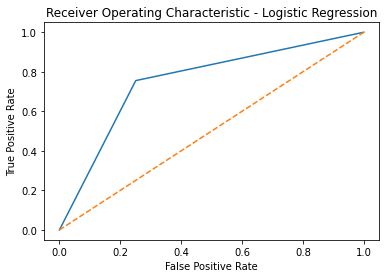

In [10]:
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
get_odds_ratios(log_reg)


Odds Ratios:
                         OR
game_win_rate      9.633022
underdog           2.029789
fan_favorite       1.533933
poss_per_game_opp  1.505761
fga_opp            1.163901
...                     ...
srs_opp            0.858930
poss_per_game      0.730106
fan_favorite_opp   0.650130
underdog_opp       0.522543
game_win_rate_opp  0.104239

[77 rows x 1 columns]

Prediction table:
[[13507.  4261.]
 [ 4209. 13589.]]


## 1.C Statsmodels LogReg Run with a select set of features

In [12]:
include_columns = ['won','de','oe','te','de_opp','oe_opp','te_opp','three_mean_plus_minus', 'three_mean_plus_minus_opp',
                  'game_win_rate','game_win_rate_opp','physicality_score','physicality_score_opp','win_streak','win_streak_opp']
# include_columns = ['won','de','oe','te','de_opp','oe_opp','te_opp','three_mean_plus_minus', 'three_mean_plus_minus_opp',
#                   'physicality_score','physicality_score_opp']
data2 = data[include_columns]
resp_var = data2.columns[0]
pred_vars = data2.columns[1:].tolist()

train, test = train_test_split(data2,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))
get_odds_ratios(log_reg)

         Current function value: 0.526200
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
Accuracy: 0.7257085020242915
F1-Score: 0.7265388496468212
ROC/AUC Score for Logistic Regression:  0.7258025224861528

Odds Ratios:
                                   OR
game_win_rate              496.297849
win_streak_opp               1.074286
three_mean_plus_minus        1.027679
te_opp                       1.025248
de                           1.022746
oe_opp                       1.011720
Intercept                    1.009448
physicality_score            1.004340
te                           1.000921
physicality_score_opp        0.991252
oe                           0.987354
de_opp                       0.978146
three_mean_plus_minus_opp    0.971831
win_streak                   0.934087
game_win_rate_opp            0.002273

Prediction table:
[[13042.  4763.]
 [ 4771. 12990.]]


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 2 - Sklearn Logistic Regression

In [13]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column
X.dropna(inplace=True,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LogisticRegression(max_iter=1000)  # Increase max_iter if the model doesn't converge
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(y_test, prediction))

get_odds_ratios(model)

Accuracy: 0.7679655870445344
F1-Score: 0.7676716493539397
ROC/AUC Score for Logistic Regression:  0.7679788529882114

Odds Ratios:
                           OR
game_win_rate      171.079820
poss_per_game_opp    1.786135
fan_favorite         1.509506
underdog             1.282407
tov_perc_opp         1.160143
...                       ...
tov_perc             0.892733
underdog_opp         0.825932
fan_favorite_opp     0.630188
poss_per_game        0.548147
game_win_rate_opp    0.006198

[76 rows x 1 columns]


C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


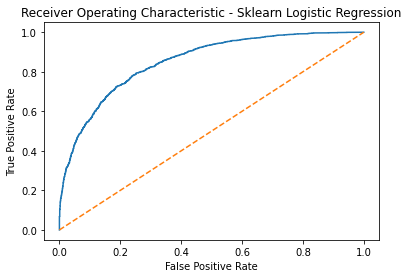

In [14]:
plt.title('Receiver Operating Characteristic - Sklearn Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3 - Xgboost

In [15]:
pd.options.display.max_columns = 100

In [16]:
model = XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100, 
    learning_rate = 0.02,
    max_depth = 5,
    gamma = 5,
    min_child_weight = 10,
    subsample = .8
)
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Xgboost: ', roc_auc_score(y_test, prediction))

# get_odds_ratios(model)

Accuracy: 0.7621457489878543
F1-Score: 0.7634625062908907
ROC/AUC Score for Xgboost:  0.7621934415783321


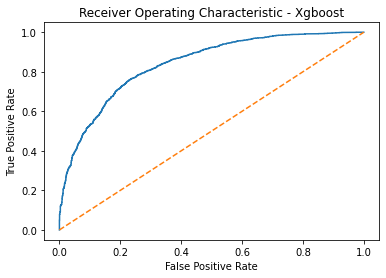

In [17]:
plt.title('Receiver Operating Characteristic - Xgboost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Grid Search for Xgboost

In [18]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [20]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

In [21]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[08:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



 Time taken: 0 hours 1 minutes and 0.28 seconds.


In [22]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([10.33469272,  6.80475752,  8.73003109, 10.24086746, 12.64500658]), 'std_fit_time': array([0.11307797, 0.2227405 , 0.15809793, 0.04474016, 0.42874541]), 'mean_score_time': array([0.08896089, 0.08884382, 0.09930348, 0.08223065, 0.06928992]), 'std_score_time': array([0.00767502, 0.0045594 , 0.00800214, 0.01100771, 0.00644864]), 'param_subsample': masked_array(data=[0.8, 0.8, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 5, 5, 10, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 3, 5, 4, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[2, 0.5, 1, 0.5, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
      

## Gradient Boosted Trees

In [23]:
X.dropna(inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize the Gradient Boosting Classifier
gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model on the training data
gbt_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = gbt_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.81%


## Hist Gradient Boosted Classifier

In [24]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column
# X.dropna(inplace=True,axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize the Histogram-based Gradient Boosting Classifier
hist_gbt_model = HistGradientBoostingClassifier(max_iter=100)

# Train the model on the training data
hist_gbt_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = hist_gbt_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.21%


#### Perform Hyperparameter Tuning

In [25]:
# Initialize the Histogram-based Gradient Boosting Classifier
hist_gbt_model = HistGradientBoostingClassifier()

# Define the hyperparameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [50, 100, 150],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization':[0,0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=hist_gbt_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(X_test)

# Evaluate the accuracy of the best model
accuracy = accuracy_score(y_test, predictions)
print(f"Best Parameters: {best_params}")
print(f"Best Model Accuracy: {accuracy * 100:.2f}%")

Best Parameters: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100, 'min_samples_leaf': 20}
Best Model Accuracy: 78.11%


# Probablistic Models
### Gaussian Naive Bayes

In [27]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column
X.dropna(inplace=True,axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize the Gaussian Naive Bayes model
gnb_model = GaussianNB()

# Train the model on the training data
gnb_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = gnb_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 72.24%


# Deterministic Models

### Basic FNN (Feedforward Neural Network)

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np
# import pandas as pd

data = pd.read_csv('../data/model_features.csv')
data.dropna(inplace=True, axis=1)

# Check for duplicates
num_duplicates = data.loc[data.duplicated()].shape[0]
print(f'{num_duplicates} duplicates')
if num_duplicates > 0:
#     print(data.loc[data.duplicated()].head())
    data = data.drop_duplicates()
    print('duplicates removed')

y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column

y_one_hot = tf.keras.utils.to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, 
          validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

ModuleNotFoundError: No module named 'tensorflow'

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
import numpy as np
import math

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# test
scores = np.array([ -0.54761371,  17.04850603,   4.86054302])
print(sigmoid_v(scores))

[0.36641822 0.99999996 0.99231327]


In [44]:
MinMaxScaler().fit_transform([[-1,0,1],[-1,0,1],[-1,0,1]])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])